In [72]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.metrics import Precision
from sklearn.model_selection import train_test_split 
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn.metrics

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Подгружаем датасет, чистим от мусора, преобразуем данные к единому формату**

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Стажировка/data2.xlsx')

In [5]:
column_list = df.columns.tolist()

In [6]:
df_1 = df.dropna(axis=0, how='all')
df_2 = df_1.dropna(axis=1, how='all')

In [7]:
df_list_1 = []
for i in column_list:
  if "МКБ" in i:
    df_list_1.append(i)

In [8]:
df2=df_2[df_list_1]

In [9]:
df2.fillna(0, inplace=True)

<ipython-input-9-32f74130add2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.fillna(0, inplace=True)


In [10]:
df3=df[[
  'КлиентДатаРождения',
  'КлиентПол',
  'Профессия',
  'ЗаключениеМК',
  'ДиспансернаяГруппа',
  'ВредныеФакторы']]

In [11]:
df_full=pd.concat([df3,df2], axis=1, sort=False)

In [12]:
df_full_1=df_full.dropna(subset=['ЗаключениеМК'])

In [13]:
df_full_1['КлиентДатаРождения'] = pd.to_datetime(df_full_1['КлиентДатаРождения'], errors="coerce")
df_full_1["Возраст"] = \
    (pd.to_datetime("today") - df_full_1["КлиентДатаРождения"]).astype('<m8[Y]')

<ipython-input-13-b3a31f71bf19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_1['КлиентДатаРождения'] = pd.to_datetime(df_full_1['КлиентДатаРождения'], errors="coerce")
<ipython-input-13-b3a31f71bf19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_1["Возраст"] = \


In [14]:
df_full_1['КлиентДатаРождения']=df_full_1["Возраст"]

<ipython-input-14-d8f2baee0d43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_1['КлиентДатаРождения']=df_full_1["Возраст"]


In [15]:
df_full_1 = df_full_1.drop(columns='Возраст')

In [16]:
df_full_1.loc[df_full_1['КлиентПол'] == "Женский", 'КлиентПол'] = 0
df_full_1.loc[df_full_1['КлиентПол'] == "Мужской", 'КлиентПол'] = 1

In [17]:
df_full_1["КлиентДатаРождения"]=df_full_1["КлиентДатаРождения"].astype (int)

In [18]:
def getParameterAgeVect(arg):
    outClass =int((arg-13)/5)
    outClass = max(0, min(10,outClass))
    return outClass

In [19]:
df_full_1['ВозрастКатегория'] = df_full_1['КлиентДатаРождения'].apply(getParameterAgeVect)

In [20]:
df_full_1 = df_full_1.drop(columns='КлиентДатаРождения')

In [21]:
df_full_1["ЗаключениеМК"].unique ()

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден', 'машинист бульдозера', 'Газоспасатель',
       ' Газоспасатель'], dtype=object)

**"машинист бульдозера", 'Газоспасатель', ' Газоспасатель' - явно лишние в заключении мед комиссии. **

In [22]:
new = df_full_1.loc[~df['ЗаключениеМК'].isin(["машинист бульдозера", 'Газоспасатель', ' Газоспасатель'])]

In [23]:
new["ЗаключениеМК"].unique()

array(['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах',
       'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден',
       'ОграниченноГоден'], dtype=object)

**Разделяю на 2 класса.**

**0 = годен,**

**1  =Ограниченно годен, ВременноНегоден, НуждаетсяВДообследованииИЛечении и др.**

**Кол-ва примеров в датасэте недостаточно для получения большей точности на большем кол-ве классов. Необходимо увеличить кол-во примеров для других классов кроме класса годен.**

In [24]:
new.loc[new['ЗаключениеМК'] == "Годен", 'ЗаключениеМК'] = 0
new.loc[new['ЗаключениеМК'] == "ГоденСКоррекциейЗрения", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ГоденБезРаботНаВысотах", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "НуждаетсяВДообследованииИЛечении", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ВременноНегоден", 'ЗаключениеМК'] = 1
new.loc[new['ЗаключениеМК'] == "ОграниченноГоден", 'ЗаключениеМК'] = 1

In [26]:
# преобразуем коды МКБ
list_of_alf=(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
list_of_alf

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [27]:
for i in list_of_alf:
  print("     new[i] = new[i].astype(str).str.replace(","'",i,"',","'","0.",25-list_of_alf.index(i)+1,"'",")", sep='')

     new[i] = new[i].astype(str).str.replace('A','0.26')
     new[i] = new[i].astype(str).str.replace('B','0.25')
     new[i] = new[i].astype(str).str.replace('C','0.24')
     new[i] = new[i].astype(str).str.replace('D','0.23')
     new[i] = new[i].astype(str).str.replace('E','0.22')
     new[i] = new[i].astype(str).str.replace('F','0.21')
     new[i] = new[i].astype(str).str.replace('G','0.20')
     new[i] = new[i].astype(str).str.replace('H','0.19')
     new[i] = new[i].astype(str).str.replace('I','0.18')
     new[i] = new[i].astype(str).str.replace('J','0.17')
     new[i] = new[i].astype(str).str.replace('K','0.16')
     new[i] = new[i].astype(str).str.replace('L','0.15')
     new[i] = new[i].astype(str).str.replace('M','0.14')
     new[i] = new[i].astype(str).str.replace('N','0.13')
     new[i] = new[i].astype(str).str.replace('O','0.12')
     new[i] = new[i].astype(str).str.replace('P','0.11')
     new[i] = new[i].astype(str).str.replace('Q','0.10')
     new[i] = new[i].astype(str

In [28]:
new2=new.copy()

In [29]:
new2.fillna(0, inplace=True)

In [30]:
new.fillna(0, inplace=True)

<ipython-input-30-8cba954ed67a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.fillna(0, inplace=True)


In [31]:
for i in df_list_1:
  new[i] = new[i].astype(str).str.replace('.','')

<ipython-input-31-7b0ed68127fe>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  new[i] = new[i].astype(str).str.replace('.','')
<ipython-input-31-7b0ed68127fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new[i] = new[i].astype(str).str.replace('.','')


In [32]:
new=new.drop(columns="ДиспансернаяГруппа")

In [35]:
for i in new:
     new[i] = new[i].astype(str).str.replace('A','0.26')
     new[i] = new[i].astype(str).str.replace('B','0.25')
     new[i] = new[i].astype(str).str.replace('C','0.24')
     new[i] = new[i].astype(str).str.replace('D','0.23')
     new[i] = new[i].astype(str).str.replace('E','0.22')
     new[i] = new[i].astype(str).str.replace('F','0.21')
     new[i] = new[i].astype(str).str.replace('G','0.20')
     new[i] = new[i].astype(str).str.replace('H','0.19')
     new[i] = new[i].astype(str).str.replace('I','0.18')
     new[i] = new[i].astype(str).str.replace('J','0.17')
     new[i] = new[i].astype(str).str.replace('K','0.16')
     new[i] = new[i].astype(str).str.replace('L','0.15')
     new[i] = new[i].astype(str).str.replace('M','0.14')
     new[i] = new[i].astype(str).str.replace('N','0.13')
     new[i] = new[i].astype(str).str.replace('O','0.12')
     new[i] = new[i].astype(str).str.replace('P','0.11')
     new[i] = new[i].astype(str).str.replace('Q','0.10')
     new[i] = new[i].astype(str).str.replace('R','0.9')
     new[i] = new[i].astype(str).str.replace('S','0.8')
     new[i] = new[i].astype(str).str.replace('T','0.7')
     new[i] = new[i].astype(str).str.replace('U','0.6')
     new[i] = new[i].astype(str).str.replace('V','0.5')
     new[i] = new[i].astype(str).str.replace('W','0.4')
     new[i] = new[i].astype(str).str.replace('X','0.3')
     new[i] = new[i].astype(str).str.replace('Y','0.2')
     new[i] = new[i].astype(str).str.replace('Z','0.1')

In [36]:
type(new["ПсихиатрияНаркология1_МКБ101"][0])

str

_____________________________

In [37]:
new['СписокВредныхФакторов'] = new['ВредныеФакторы'].apply(lambda x: x.replace('.', 'x'))

In [38]:
new=new.drop(columns="ВредныеФакторы")

_____________________________

In [40]:
# Профессия
xTrainProf = new['Профессия'] 
print(xTrainProf[0]) # пример 

Ведущий специалист по организации обуения


In [41]:
maxWordsCount = 10000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainProf) 
items = list(tokenizer.word_index.items())  

In [42]:
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainProf) 

In [43]:
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) 
print(xTrainProf01.shape)                                      
print(xTrainProf01[0][0:100])  

(1571, 10000)
[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [44]:
n = 0
print(xTrainProf[n])       
print(xTrainProfIndexes[n]) 

Ведущий специалист по организации обуения
[6, 5, 3, 189, 309]


____________________________

In [45]:
#СписокВредныхФакторов
xTrainFactor = new['СписокВредныхФакторов'] 
print(xTrainFactor[10])

11x1


In [46]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainFactor) 
items = list(tokenizer.word_index.items())  

In [47]:
xTrainFactorIndexes = tokenizer.texts_to_sequences(xTrainFactor) 

In [48]:
xTrainFactor01 = tokenizer.sequences_to_matrix(xTrainFactorIndexes) 
print(xTrainFactor01.shape)                                      
print(xTrainFactor01[0][0:100])  

(1571, 1000)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [49]:
n = 0
print(xTrainFactor[n])       
print(xTrainFactorIndexes[n])

11x4
[14]


_______________________________

In [ ]:
for i in new:
  print("                             ","'",i,"'", ",", sep="")

In [51]:
new_ohe = pd.get_dummies(new, columns=['КлиентПол',
                             'ПсихиатрияНаркология1_МКБ101',
                             'Офтальмология1_МКБ101',
                             'Оториноларингология1_МКБ101',
                             'ХирургНеИсп1_МКБ101',
                             'Гинекология1_МКБ101',
                             'Стоматология1_МКБ101',
                             'Дерматовенерология1_МКБ101',
                             'Рентгенология1_МКБ101',
                             'Неврология1_МКБ101',
                             'Терапия1_МКБ101',
                             'Хирургия1_МКБ101',
                             'Офтальмология1_МКБ102',
                             'Терапия2_МКБ101',
                             'Неврология2_МКБ101',
                             'ЛабораторныеИсследования1_МКБ101',
                             'ЭКГНеИсп1_МКБ101',
                             'УЗИДиагностика1_МКБ101',
                             'УЗИДиагностика2_МКБ101',
                             'ПсихиатрияНаркология2_МКБ101',
                             'Терапия1_МКБ102',
                             'ЛабораторныеИсследования2_МКБ101',
                             'Терапия1_МКБ103',
                             'Психиатрия1_МКБ101',
                             'Гинекология1_МКБ102',
                             'Рентгенология2_МКБ101',
                             'Гинекология2_МКБ101',
                             'Хирургия2_МКБ101',
                             'ПроцедурнаяМедсестра1_МКБ101',
                             'ФункциональнаяДиагностика1_МКБ101',
                             'УЗИДиагностика1_МКБ102',
                             'Стоматология2_МКБ101',
                             'Неврология1_МКБ102',
                             'Оториноларингология2_МКБ101',
                             'Дерматовенерология1_МКБ102',
                             'Дерматовенерология2_МКБ101',
                             'Дерматовенерология2_МКБ102',
                             'Хирургия1_МКБ102',
                             'Хирургия2_МКБ102',
                             'Офтальмология2_МКБ101',
                             'Офтальмология2_МКБ102',
                             'Неврология2_МКБ102',
                             'ПсихиатрияНаркология1_МКБ102',
                             'ПсихиатрияНаркология2_МКБ102',
                             'УЗИДиагностика2_МКБ102',
                             'Оториноларингология1_МКБ102',
                             'Оториноларингология2_МКБ102',
                             'Терапия2_МКБ102',
                             'Оториноларингология1_МКБ103',
                             'Оториноларингология1_МКБ104',
                             'Оториноларингология2_МКБ103',
                             'Оториноларингология2_МКБ104',
                             'Терапия3_МКБ101',
                             'Терапия3_МКБ102',
                             'Терапия4_МКБ101',
                             'Терапия4_МКБ102',
                             'Гинекология2_МКБ102',
                             'УЗИДиагностика1_МКБ103',
                             'УЗИДиагностика1_МКБ104',
                             'УЗИДиагностика2_МКБ103',
                             'УЗИДиагностика2_МКБ104',
                             'Стоматология1_МКБ102',
                             'Стоматология2_МКБ102',
                             'Терапия1_МКБ104',
                             'Терапия2_МКБ103',
                             'Терапия2_МКБ104',
                             'Офтальмология1_МКБ103',
                             'Офтальмология1_МКБ104',
                             'Офтальмология2_МКБ103',
                             'Офтальмология2_МКБ104',
                             'ЛабораторныеИсследования1_МКБ102',
                             'ЛабораторныеИсследования2_МКБ102',
                             'Хирургия3_МКБ101',
                             'Гинекология3_МКБ101',
                             'Гинекология3_МКБ102',
                             'Гинекология4_МКБ101',
                             'Гинекология4_МКБ102',
                             'ТерапевтНеИсп1_МКБ101',
                             'Эндоскопия1_МКБ101',
                             'ТерапевтНеИсп1_МКБ102',
                             'ХирургНеИсп1_МКБ102',
                             'ХирургНеИсп2_МКБ101',
                             'ХирургНеИсп2_МКБ102',
                             'Психиатрия1_МКБ102',
                             'Психиатрия2_МКБ101',
                             'Психиатрия2_МКБ102',
                             'Рентгенология1_МКБ102',
                             'Рентгенология2_МКБ102',
                             'Психиатрия3_МКБ101',
                             'Психиатрия3_МКБ102',
                             'Психиатрия4_МКБ101',
                             'Психиатрия4_МКБ102',
                             'Оториноларингология3_МКБ101',
                             'ВозрастКатегория',
                           ])

In [52]:
new_ohe=new_ohe.drop(columns="Профессия")

In [53]:
new_ohe=new_ohe.drop(columns="СписокВредныхФакторов")
new_ohe=new_ohe.drop(columns="ЗаключениеМК")

In [56]:
colms5 = new_ohe.columns.values.tolist()

In [57]:
yTrain = new['ЗаключениеМК'].to_numpy()

In [58]:
yTrain = yTrain.astype(float)

In [59]:
yTrain

array([0., 0., 1., ..., 0., 0., 0.])

In [60]:
yTrain.shape

(1571,)

In [61]:
new_ohe = new_ohe.astype(float)

In [62]:
xTrain01 = new_ohe.to_numpy()

In [63]:
xTrain01

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [64]:
xTrain01.shape

(1571, 376)

In [66]:
x_train, x_test, x_train_text1, x_test_text1, x_train_text2, x_test_text2, y_train, y_test = train_test_split(xTrain01,
                                                                                                              xTrainProf01, 
                                                                                                              xTrainFactor01,
                                                                                                              yTrain, 
                                                                                                              test_size=0.25,
                                                                                                              shuffle = False)

In [67]:
# Визуальная оценка ошибки на обучающей и проверочной выборках
def compare_sharp_loss (history, x_size, y_size):
  
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающей выборке')
  
  plt.plot(history.history['val_loss'], 
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

___________________________________

_________________________________________

# **Создаем модель, обучаем модель**

In [68]:
input1 = Input((x_train.shape[1],))
input2 = Input((x_train_text1.shape[1],))
input3 = Input((x_train_text2.shape[1],))  

Epoch 1/200
26/26 [==============================] - 6s 65ms/step - loss: 2.1842 - mae: 1.3518 - val_loss: 1.4480 - val_mae: 1.1707
Epoch 2/200
26/26 [==============================] - 2s 78ms/step - loss: 1.9511 - mae: 1.2598 - val_loss: 1.1974 - val_mae: 1.0583
Epoch 3/200
26/26 [==============================] - 2s 88ms/step - loss: 1.7397 - mae: 1.1842 - val_loss: 0.9582 - val_mae: 0.9388
Epoch 4/200
26/26 [==============================] - 2s 89ms/step - loss: 1.5435 - mae: 1.1074 - val_loss: 0.8430 - val_mae: 0.8808
Epoch 5/200
26/26 [==============================] - 2s 94ms/step - loss: 1.4026 - mae: 1.0497 - val_loss: 0.8214 - val_mae: 0.8699
Epoch 6/200
26/26 [==============================] - 1s 50ms/step - loss: 1.2855 - mae: 0.9853 - val_loss: 0.6933 - val_mae: 0.8040
Epoch 7/200
26/26 [==============================] - 1s 47ms/step - loss: 1.1183 - mae: 0.9204 - val_loss: 0.6054 - val_mae: 0.7542
Epoch 8/200
26/26 [==============================] - 1s 48ms/step - loss: 0.

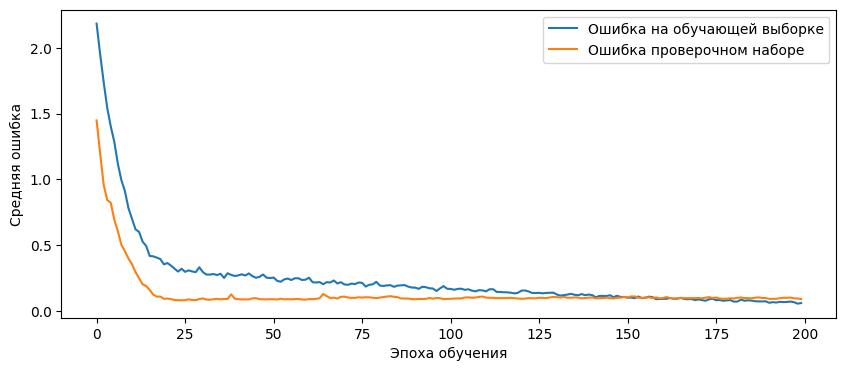

In [79]:
x1 = BatchNormalization()(input1) 
x1 = Dense(1024, activation='relu') (x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(768, activation='sigmoid')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(512, activation='sigmoid')(x1)

x2 = Dense(100, activation='sigmoid') (input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(100, activation='sigmoid') (x2)


x3 = Dense(100, activation='sigmoid') (input3)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.3)(x3)
x3 = Dense(100, activation='sigmoid') (x3)

x = concatenate([x1, x2, x3])

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(50, activation='sigmoid')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2, input3), x) 

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=["mae"])

history = model.fit((x_train, x_train_text1, x_train_text2), 
                    y_train, 
                    epochs= 200, 
                    validation_split = 0.3,
                    verbose=1, shuffle=True)

compare_sharp_loss(history,10,4) 

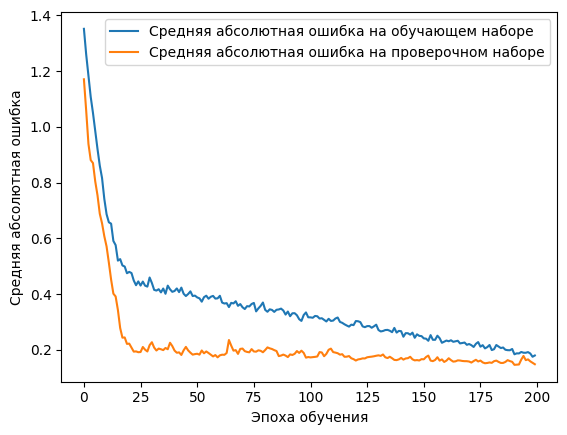

In [80]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

13/13 [==============================] - 0s 9ms/step


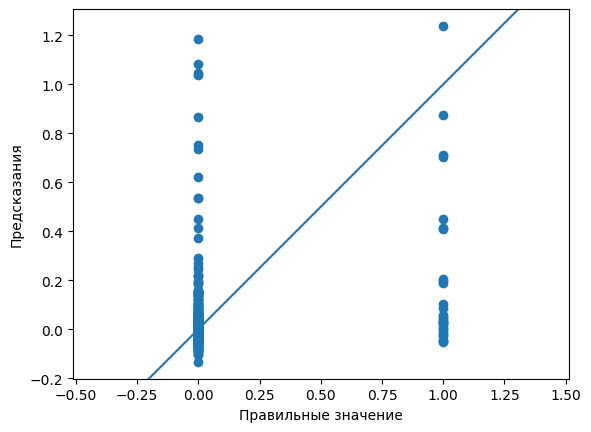

In [81]:
pred = model.predict([x_test, x_test_text1, x_test_text2]) 
plt.scatter(y_test, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])
plt.show()

In [82]:
m_l = []
s = 0
for i in range(0, len(y_test)):
    if np.round(y_test[i]) == np.round(pred[i]):
        s += 1
    dif = (y_test[i] - pred[i])**2
    print(y_test[i], pred[i], dif, np.round(y_test[i]), np.round(pred[i]))
    m_l.append(dif)

print('Среднеквадратичное отклонение', np.sqrt(np.mean(m_l)))
print('Точность модели', s / len(y_test))

0.0 [-0.02839546] [0.0008063] 0.0 [-0.]
0.0 [-0.00374721] [1.4041582e-05] 0.0 [-0.]
0.0 [0.02917601] [0.00085124] 0.0 [0.]
0.0 [-0.13322498] [0.01774889] 0.0 [-0.]
1.0 [0.05053312] [0.90148735] 1.0 [0.]
0.0 [-0.02051258] [0.00042077] 0.0 [-0.]
0.0 [0.01798247] [0.00032337] 0.0 [0.]
0.0 [0.0438047] [0.00191885] 0.0 [0.]
0.0 [0.11917882] [0.01420359] 0.0 [0.]
0.0 [-0.03579614] [0.00128136] 0.0 [-0.]
0.0 [0.0438047] [0.00191885] 0.0 [0.]
0.0 [0.03325622] [0.00110598] 0.0 [0.]
1.0 [-0.01186821] [1.0238774] 1.0 [-0.]
0.0 [0.085956] [0.00738843] 0.0 [0.]
0.0 [0.04825601] [0.00232864] 0.0 [0.]
0.0 [-0.05024405] [0.00252446] 0.0 [-0.]
0.0 [0.02260817] [0.00051113] 0.0 [0.]
0.0 [0.00042941] [1.8439657e-07] 0.0 [0.]
1.0 [0.8740726] [0.01585771] 1.0 [1.]
0.0 [-0.05732799] [0.0032865] 0.0 [-0.]
0.0 [0.0064513] [4.161924e-05] 0.0 [0.]
1.0 [0.04268584] [0.9164503] 1.0 [0.]
0.0 [-0.05663648] [0.00320769] 0.0 [-0.]
0.0 [0.13597369] [0.01848884] 0.0 [0.]
0.0 [0.02539372] [0.00064484] 0.0 [0.]
0.0 [-0.0

**Увеличение кол-ва эпох не повлияло на точность. Другие манипуляции вряд-ли приведут к улучшению результата. Необходимо увеличить кол-во примеров других классов (Не годен, Временно не годен, Ограниченно годен и др.), на данный момент их можно пересчитать по пальцам в отличии от класса Годен, что создает проблемы при обучении сети (при DL). Даже пришлось разбить датасет на 2 класса (Годен и все остальное) вместо 3. Почистил код, улучшил внешний вид. Точность около 91 % считаю неплохим результатом для тестовой модели на deep learning. Финальный вариант с большим датасэтом (если заказчик предоставит) будет явно лучше нынешнего результата.**

________________________________________


____________________________________

_____________________________________________